ARIMA model is used to predict times series and is based on the assumption of constant autocorrelations in the series for any given lag.

ARIMA stands for autoregressive (AR), integrated (I), moving average model (MA). AR part models future observations based on previous observations. MA part utilizes past residuals to make predictions. I part is order of differencing to make time series stationary if necessary.

I will try to explain why time series needs to be stationary to apply ARIMA. By the way there are 2 main forms of stationarity - weak and strong and i am referring to weak stationarity above as a requirement. Time series is weakly stationary if it's mean, variance and autocorrelations don't change over time. 

Here is why it needs to be stationary. ARIMA is using historic autocorrelations between values to predict future observations. It works well if autocorrelations as well as mean and variance stay the same. If it's not the case then ARIMA is not suitable for forecasting. There are various tests to check whether time series is stationary. Different types of transofrmations as well as detrending and differencing are used to bring it closer to stationarity so ARIMA can be used later on.

Now I will create a time series in python:

In [1]:
#Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
%matplotlib inline

<br>
<br>
AR(2) process is simply ARIMA(2,0,0). To simulate such process every observarion needs to be created as a function of 2 previous observations:

In [2]:
x = np.zeros(1000)
#e is a random noise, it follows normal distribution with mean 0 and variance 1 
e = np.random.normal(size=1000)
for t in range(1000):
    x[t] = 0.7*x[t-1] + 0.2*x[t-2] + e[t]

<br>
Let's see if ARIMA will be able to find correct coefficients for the simulated time series above. Autocorrelations (ACF) and partial autocorrelations (PACF) between observations at a given lag helps to determine which ARIMA model can be used.

Statsmodels library has functions to create ACF and PACF charts. As autocorrelations may arise by a chance i am using 95% confidence intervals. Partial autocorrelation at lag N is calculated after accounting for all correlations at lower lags and is similar to a regression coefficient (coefficient for lag N in a regression built on lags 1 through N).

In [3]:
def ch(x, x_title, lags=30):
    #the below context manager will make style changes only for the charts created by this function
    print('Dickey-Fuller test p-value: ', sm.tsa.stattools.adfuller(x)[1])
    with plt.style.context('seaborn'):
        fig = plt.figure(figsize=(10,8))
        #plot of X
        ax = plt.subplot(311)
        ax.plot(x)
        ax.set_title(x_title)
        #ACF
        acf = plt.subplot(323)
        #alpha parameter is to show confidence intervals at specified level
        smt.graphics.plot_acf(x, ax=acf, lags=lags, alpha=0.05, title='ACF')
        #PACF
        pacf = plt.subplot(324)
        smt.graphics.plot_pacf(x, ax=pacf, lags=lags, alpha=0.05, title='PACF')
        #QQ plot
        qq = plt.subplot(325)
        sm.qqplot(x, line='s', ax=qq)
        #Probability plot
        pp = plt.subplot(326)
        scs.probplot(x, sparams=(x.mean(), x.std()), plot=pp)
        plt.tight_layout()

<br>
Dickey-Fuller test helps to determine if a process is non stationary and any transformations are needed. According to the statistic below null hypothesis can be rejected so the time series is stationary and tranformation is not needed to use ARIMA.

Also PACF chart only shows that lags 1 and 2 are significant so AR(2) model or linear regression with first 2 lags can be used to model the process. And that's exactly how time series $x$ was created: $x_t = 0.7x_{t-1} + 0.2x_{t-2} + e_{t}$ where $e_t$ is a random noise.

Dickey-Fuller test p-value:  4.718202152492504e-09


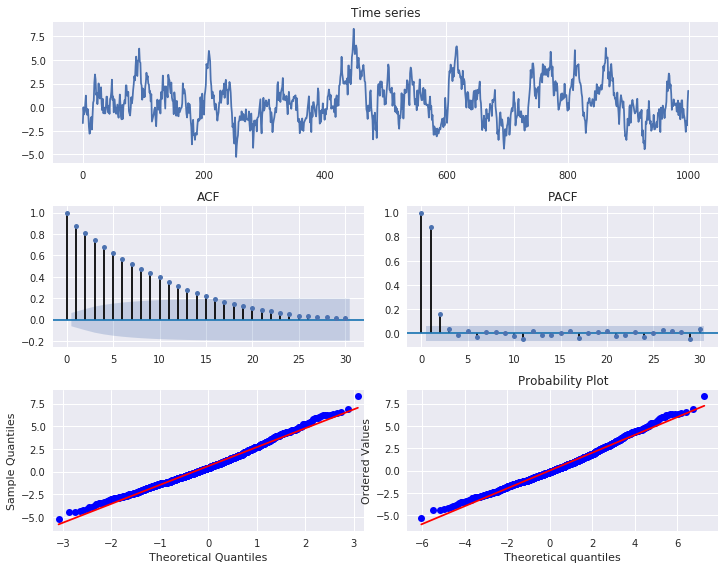

In [4]:
ch(x, 'Time series')

Fitting ARIMA(2,0,0) model which is the same as AR(2) shows significant coefficients for lag1 and lag2 and close to 0.7 and 0.2 which were used to create the time series above. So AR(2) model was able to find correct coefficients.

In [5]:
SARIMAX(x, order=(2,0,0), trend='c').fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -1405.453
Date:                Sat, 23 Nov 2019   AIC                           2818.907
Time:                        10:29:56   BIC                           2838.538
Sample:                             0   HQIC                          2826.368
                               - 1000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0621      0.032      1.929      0.054      -0.001       0.125
ar.L1          0.7406      0.030     24.484      0.000       0.681       0.800
ar.L2          0.1556      0.032      4.905      0.000       0.093       0.218
sigma2         0.9719      0.045     21.488      0.000       0.883       1.061
===================================================================================
Ljung-Box (Q):                       31.23   Jarque-Bera (JB):                 1.35
Prob(Q):                              0.84   Prob(JB):                         0.51
Heteroskedasticity (H):               0.87   Skew:                             0.05
Prob(H) (two-sided):                  0.19   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<br>
<br>
<br>
Now i would like to see whether linear regression on the first 2 lags of x produces similar results. Based on the below output it does with similar coefficients for lagged variables as AR(2). 

The output also shows no remaining correlations in the residuals according to Durbin-Watson statistic (it's close to 2). Skeweness and kurtosis numbers as well as Omnibus and Jarque-Bera tests (can't reject null hypothesis) indicate normal distribution of the residuals. 

In [6]:
#array x_end contains lag1 and lag2 of x
x_end = np.column_stack((np.roll(x, 1), np.roll(x, 2)))
x_end = sm.add_constant(x_end)
ols = sm.OLS(x[2:], x_end[2:]).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     1725.
Date:                Sat, 23 Nov 2019   Prob (F-statistic):          4.94e-324
Time:                        10:29:59   Log-Likelihood:                -1401.3
No. Observations:                 998   AIC:                             2809.
Df Residuals:                     995   BIC:                             2823.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0651      0.033      1.996      0.046       0.001       0.129
x1             0.7414      0.031     23.679      0.000       0.680       0.803
x2             0.1555      0.031      4.968      0.000       0.094       0.217
==============================================================================
Omnibus:                        1.197   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.550   Jarque-Bera (JB):                1.260
Skew:                           0.053   Prob(JB):                        0.533
Kurtosis:                       2.862   Cond. No.                         4.12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<br>
<br>
<br>
Residuals of the linear regression indicate no correlation with fitted values based on the chart below. 

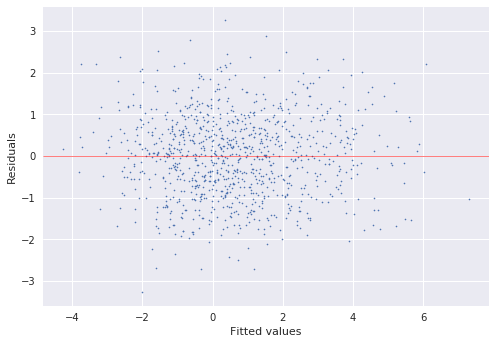

In [7]:
with plt.style.context('seaborn'):
    plt.scatter(ols.fittedvalues, ols.resid, s=1.5)
    plt.axhline(y=0, c='r', ls='-', lw=0.5)
    plt.ylabel("Residuals")
    plt.xlabel("Fitted values")

There is also no serial correlation according to Durbin-Watson and Breusch-Godfrey tests (can't reject null hypothesis) and ACF/PACF charts.

Breusch-Godfrey statistic:
(9.553608269662236, 0.9841463254249092, 0.4482847566935744, 0.9851092008506201)
Dickey-Fuller test p-value:  0.0


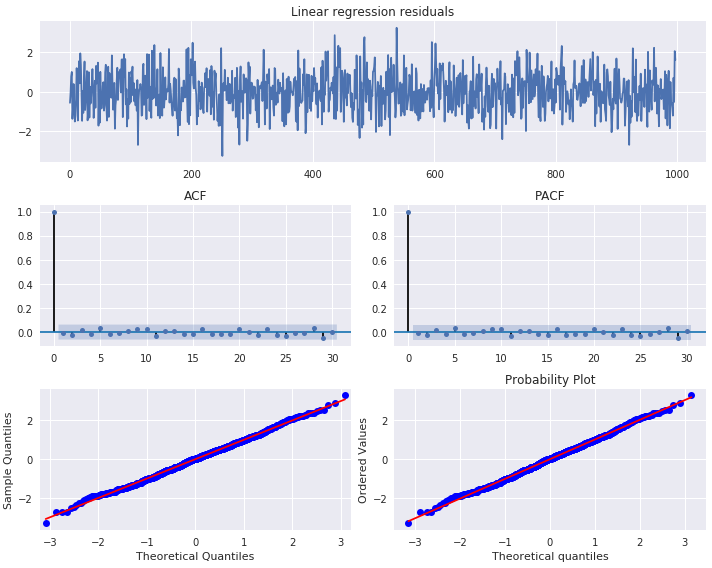

In [8]:
print("Breusch-Godfrey statistic:")
print(sm.stats.diagnostic.acorr_breusch_godfrey(ols))
ch(ols.resid, 'Linear regression residuals')

Residual variance is constant based on the residuals chart above and a few tests for heteroscedasticity below (can't reject null hypothesis). 

In [9]:
print(sm.stats.diagnostic.het_white(sm.OLS(x, x_end).fit().resid, x_end))
print(sm.stats.diagnostic.het_goldfeldquandt(sm.OLS(x, x_end).fit().resid, x_end))

(6.063072124252389, 0.3001300256427166, 1.2126913735637472, 0.3009854655614594)
(0.8785624939471789, 0.9253376884002187, 'increasing')


All of the above indicate that the linear model was able to represent relationship between dependent and independent variables so well that no predictive information remains in the residuals - only random noise is left. The model satisfies Gauss-Markov conditions and according to $R^2$ fits data pretty well.

Let's look at MA moving average model. It utilizes past error information to predict future values. MA(1) model is simulated below:

In [10]:
x = np.zeros(1000)
e = np.random.normal(size=1000)
for t in range(1000):
    x[t] = 0.9*e[t-1] + e[t]

Now ACF chart shows the only significant correlation at lag 1 but PACF chart shows quite a few significant correlated lags while absolute values of the correlations are decaying which is vice versa from AR model before.

The reason only lag 1 shows significant correlation on ACF graph is because the time series is built from previous error values or white noise and white noise values should have covariance close to 0. So only observations lagged 1 step have non zero correlation based on the formula for the time series: $x_t = 0.9e_{t-1} + e_t$ and all other lags are not correlated.

The reason PACF chart shows multiple significant correlations is below.

Each error term can be presented as 

$$e_t = x_t - 0.9e_{t-1}$$

so initial time series becomes 

$$x_t = 0.9(x_{t-1} - 0.9e_{t-2}) + e_t$$

$$x_t = 0.9(x_{t-1} - 0.9(x_{t-2} - 0.9e_{t-2})) + e_t$$

and so on

$$x_t = 0.9x_{t-1} - 0.9^2x_{t-2} + 0.9^3x_{t-2} - ... - (-0.9)^tx_0 + e_t$$

or an expression with all lagged values of x. This is similar to infinite order AR model. As a result PACF graph shows mutliple significant correlated lags with decreasing absolute values - PACF or partial correlations are similar to coefficients in a linear regression.

Dickey-Fuller test p-value:  1.633964554269177e-08


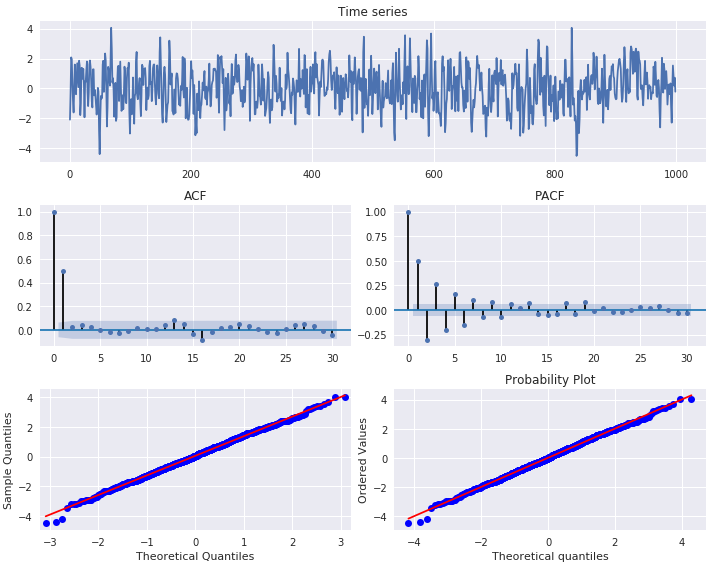

In [11]:
ch(x, "Time series")

Here is ARIMA(0,0,1) or MA(1) model results. Calculated coefficient for MA term is close to what was used to build the sequence.

In [12]:
SARIMAX(x, order=(0,0,1), trend='c').fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -1410.665
Date:                Sat, 23 Nov 2019   AIC                           2827.330
Time:                        10:30:18   BIC                           2842.053
Sample:                             0   HQIC                          2832.926
                               - 1000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0563      0.059      0.956      0.339      -0.059       0.172
ma.L1          0.8814      0.016     55.026      0.000       0.850       0.913
sigma2         0.9821      0.044     22.318      0.000       0.896       1.068
===================================================================================
Ljung-Box (Q):                       31.14   Jarque-Bera (JB):                 0.00
Prob(Q):                              0.84   Prob(JB):                         1.00
Heteroskedasticity (H):               1.02   Skew:                            -0.00
Prob(H) (two-sided):                  0.85   Kurtosis:                         2.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

AR and MA processes can be identified by patterns on PACF and ACF graphs respectively as shown before. But for a process with both AR and MA terms (ARMA process) it is not so easy to do. For example this is how ARIMA(1,0,1) ACF and PACF look like.

In [13]:
x = np.zeros(1000)
e = np.random.normal(size=1000)
for t in range(1000):
    x[t] = 0.6*x[t-1] + 0.3*e[t-1] + e[t]

ACF and PACF charts below don't provide an easy solution to which ARIMA model should be used in this case.

Dickey-Fuller test p-value:  1.1026078072349189e-26


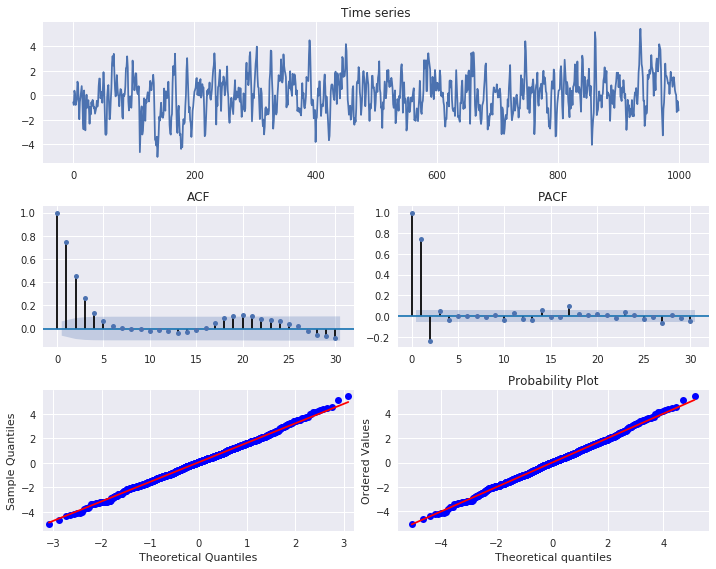

In [14]:
ch(x, "Time series")

Python has a package with auto arima-function to identify best fitting arima model by building a number of models and selecting one with the best information criteria - Akaike information criterion is used by default.

In [15]:
from pmdarima.arima import auto_arima
aa = auto_arima(x, suppress_warnings=True, error_action="ignore")
print(aa)
print("Akaike information criterion :", aa.aic())
aa.summary()

/home/kostya/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/kostya/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(1, 1, 2),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(0, 0, 0, 1), solver='lbfgs', start_params=None,
      suppress_warnings=True, transparams=True, trend=None,
      with_intercept=True)
Akaike information criterion : 2904.264905094789


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -1447.132
Date:                Sat, 23 Nov 2019   AIC                           2904.265
Time:                        10:30:31   BIC                           2928.799
Sample:                             0   HQIC                          2913.590
                               - 1000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.000      1.855      0.064   -1.77e-05       0.001
ar.L1          0.6038      0.035     17.318      0.000       0.535       0.672
ma.L1         -0.6760      0.069     -9.765      0.000      -0.812      -0.540
ma.L2         -0.3238      0.041     -7.824      0.000      -0.405      -0.243
sigma2         1.0558      0.071     14.941      0.000       0.917       1.194
===================================================================================
Ljung-Box (Q):                       42.15   Jarque-Bera (JB):                 1.91
Prob(Q):                              0.38   Prob(JB):                         0.39
Heteroskedasticity (H):               1.01   Skew:                            -0.01
Prob(H) (two-sided):                  0.91   Kurtosis:                         3.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Based on the above output ARIMA(1,0,1) was correctly selected as the best model with AIC = 2836.

I can create a function to perform a grid search selection based on AIC. Let's see if it will pick the same model.

In [16]:
import warnings

def auto_arima_grid(x, ar, i, ma):
    min_aic = float("inf")
    #catch_warnings context manager would only suppress warnings for this function
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        for p in range(ar+1):
            for d in range(i+1):
                for q in range(ma+1):
                    try:
                        aic = SARIMAX(x, order=(p,d,q), trend='c').fit().aic
                        if aic < min_aic:
                            min_aic = aic
                            best_params = (p, d, q)
                        print("ARIMA(%s, %s, %s), aic: %s" % (p, d, q, aic))
                    except Exception as error:
                        print("ARIMA(%s, %s, %s): " % (p, d, q), error)
                        continue
        print("Best model:")
        print("ARIMA(%s, %s, %s), aic: %s" % (best_params[0], 
                                              best_params[1], 
                                              best_params[2], 
                                              min_aic))
auto_arima_grid(x, 2, 2, 2)

ARIMA(0, 0, 0), aic: 3769.765972702475
ARIMA(0, 0, 1), aic: 3131.977109350315
ARIMA(0, 0, 2), aic: 2968.0171546047036
ARIMA(0, 1, 0), aic: 3093.8024596259074
ARIMA(0, 1, 1), aic: 3085.4828542559726
ARIMA(0, 1, 2), aic: 3038.3399001335492
ARIMA(0, 2, 0), aic: 3700.876245302369
ARIMA(0, 2, 1), aic: 3100.6092326217395
ARIMA(0, 2, 2), aic: 3092.0666731696638
ARIMA(1, 0, 0), aic: 2962.7269284791164
ARIMA(1, 0, 1), aic: 2904.1585057376815
ARIMA(1, 0, 2), aic: 2905.8692436867123
ARIMA(1, 1, 0), aic: 3089.5153679492482
ARIMA(1, 1, 1), aic: 3074.880931353985
ARIMA(1, 1, 2), aic: 2904.264905094789
ARIMA(1, 2, 0), aic: 3576.4146832621695
ARIMA(1, 2, 1), aic: 3096.1637413739036
ARIMA(1, 2, 2), aic: 3090.887975160492
ARIMA(2, 0, 0), aic: 2907.118379849184
ARIMA(2, 0, 1), aic: 2905.8240371428574
ARIMA(2, 0, 2), aic: 2907.393272429856
ARIMA(2, 1, 0), aic: 3044.9441719839892
ARIMA(2, 1, 1), aic: 2906.6568485823555
ARIMA(2, 1, 2), aic: 2905.815729958241
ARIMA(2, 2, 0), aic: 3445.188901909952
ARIMA(2, 2

It also selects ARIMA(1,0,1) with AIC = 2836 as the most optimal model.


So far i have been training models and selecting best one based on how it fits in sample. The proper way of selecting a model (tune hyperparameters) would be to run a cross validation. It allows to check model performance out of sample on multiple validation sets. Cross validation for time series is a little bit different cause of time ordering - validation sample should come right after train sample. Scikit-learn library has a function to implement such splits.

In [17]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=4)
for train, valid in tscv.split(x):
    print("train: ", (train[0], train[-1]), "validation: ", (valid[0], valid[-1]))

train:  (0, 199) validation:  (200, 399)
train:  (0, 399) validation:  (400, 599)
train:  (0, 599) validation:  (600, 799)
train:  (0, 799) validation:  (800, 999)


Based on the above, we start with 200 observations as a train set and the following 200 observations as a validation set. Then the first 400 observations become a train set and the following 200 observations become validation set and so on.

The below function trains ARIMA model with given AR, I and MA hyperparameters on train sample and makes predictions on validation set. I will be making predictions on validation set one at a time based on new incoming data points one at a time another words not using predicted data points at all. That's why i need to use filter function below. If i were to use fit function it would recalculate ARIMA coefficients every time it sees new observations.

Another way to test model performance is to predict series of observations at a time. In this case model is also trained on a train dataset but then is not fed any new data points but generates a series of predicted values at once. Each subsequent predicted value is based on previous predicted values in this scenario and i will also implement this later in this project.

In [18]:
from sklearn.metrics import mean_squared_error
def cv(x, n, p, d, q):
    tscv = TimeSeriesSplit(n_splits=n)
    mse = [] 
    for train, valid in tscv.split(x):
        model = SARIMAX(x[train], order=(p,d,q), trend='c').fit()
        predictions = SARIMAX(x, order=(p,d,q), trend='c').filter(model.params).predict(start=valid[0], end=valid[-1])
        actuals = x[valid]
        mse.append(mean_squared_error(actuals, predictions))
    return np.mean(np.array(mse)), np.std(np.array(mse))
cv(x, 4, 1, 0, 1)

(1.066126255785449, 0.05663814158299699)

The below function is the same as auto_arima_grid function from above but utilizes cross validation functionality to determine best ARIMA hyperparameters - AR, I and MA. Mean squared error statistic is calculated for every validation set. Then the average and standard deviation of these numbers for every model are printed in the output and the best model based on average of mse is selected. 

Compared to auto_arima_grid function this one allows for a better assessment of the model predictive power as  first of all, models are evaluated out of sample instead of in sample. Second, models are evaluated on multiple validation samples and average of these tests is used to determine the best one.

In [19]:
def auto_arima_grid_cv(x, n, ar, i, ma):
    min_mse = float("inf")
    #catch_warnings context manager would only suppress warnings for this function
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        for p in range(ar+1):
            for d in range(i+1):
                for q in range(ma+1):
                    try:
                        result = cv(x, n, p, d, q)
                        if result[0] < min_mse:
                            min_mse = result[0]
                            best_params = (p, d, q)
                        print("ARIMA(%s, %s, %s), mse: %s, std: %s" % 
                              (p, d, q, result[0], result[1]))
                    except Exception as error:
                        print("ARIMA(%s, %s, %s): " % (p, d, q), error)
                        continue
        print("Best model:")
        print("ARIMA(%s, %s, %s), mse: %s" % (best_params[0], 
                                              best_params[1], 
                                              best_params[2], 
                                              min_mse))
auto_arima_grid_cv(x, 4, 2, 2, 2)

ARIMA(0, 0, 0), mse: 2.5564060591045212, std: 0.3366407100713435
ARIMA(0, 0, 1), mse: 1.3507381621303713, std: 0.10374219217307612
ARIMA(0, 0, 2), mse: 1.1501919220899983, std: 0.08517155340637234
ARIMA(0, 1, 0), mse: 1.2799619814010588, std: 0.07370012315561646
ARIMA(0, 1, 1), mse: 1.2756009217504447, std: 0.07621929569663759
ARIMA(0, 1, 2), mse: 1.213486394131424, std: 0.06491595018840056
ARIMA(0, 2, 0), mse: 2.392406973996659, std: 0.1844037703885165
ARIMA(0, 2, 1), mse: 1.2826015087604294, std: 0.07272012689009358
ARIMA(0, 2, 2), mse: 1.2786494343211474, std: 0.07504170407657527
ARIMA(1, 0, 0), mse: 1.1202230654942817, std: 0.0568021238149704
ARIMA(1, 0, 1), mse: 1.066126255785449, std: 0.05663814158299699
ARIMA(1, 0, 2), mse: 1.0687111871004262, std: 0.05817323356797317
ARIMA(1, 1, 0), mse: 1.2769372278483955, std: 0.07647687205260231
ARIMA(1, 1, 1), mse: 1.2602066521794306, std: 0.06998159595475273
ARIMA(1, 1, 2), mse: 1.0926129880127395, std: 0.030895586278922613
ARIMA(1, 2, 0),

<br>
<br>
<br>
<br>
Now i will try to apply a time-series model on a real world data. There is a great public machine learning repository where i found a dataset with parking occupancy rates in Birmingham from 2016/10/04 to 2016/12/19:   

https://archive.ics.uci.edu/ml/datasets/Parking+Birmingham 


In [20]:
import pandas as pd
import datetime
dt = pd.read_csv('dataset.csv')
dt.head()

,SystemCodeNumber,Capacity,Occupancy,LastUpdated
0,BHMBCCMKT01,577,61,2016-10-04 07:59:42
1,BHMBCCMKT01,577,64,2016-10-04 08:25:42
2,BHMBCCMKT01,577,80,2016-10-04 08:59:42
3,BHMBCCMKT01,577,107,2016-10-04 09:32:46
4,BHMBCCMKT01,577,150,2016-10-04 09:59:48


<br>
SystemCodeNumber refers to a particular parking lot and there are quire a few of those to choose:

In [21]:
dt.groupby('SystemCodeNumber').count()

,Capacity,Occupancy,LastUpdated
SystemCodeNumber,,,
BHMBCCMKT01,1312,1312,1312
BHMBCCPST01,1276,1276,1276
BHMBCCSNH01,1294,1294,1294
BHMBCCTHL01,1312,1312,1312
BHMBRCBRG01,1186,1186,1186
BHMBRCBRG02,1186,1186,1186
BHMBRCBRG03,1186,1186,1186
BHMBRTARC01,88,88,88
BHMEURBRD01,1312,1312,1312


<br>
I just selected one of them below. There is definitely a seasonal pattern which changes at one point.

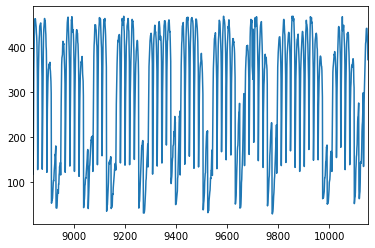

In [22]:
dt['Occupancy'][dt['SystemCodeNumber']=='BHMEURBRD01'].plot()

<br>
Taking a closer look and using datetime field as an index reveals missing data points.

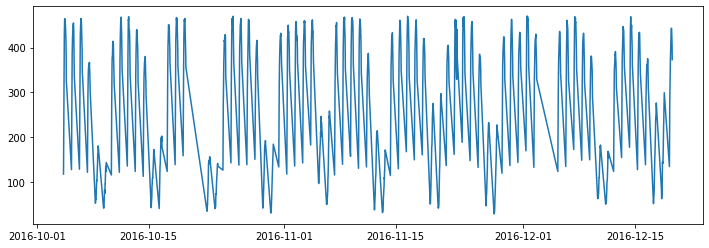

In [23]:
x = dt[['Occupancy','LastUpdated']][dt['SystemCodeNumber']=='BHMEURBRD01'].copy()
x.index = pd.to_datetime(x.LastUpdated)
plt.figure(figsize=(12,4))
plt.plot(x.Occupancy)

<br>
This way it's easier to see missing data:

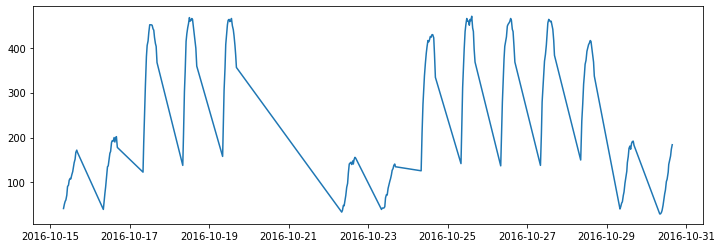

In [24]:
plt.figure(figsize=(12,4))
plt.plot(x.loc[(x.index > '2016-10-15') & (x.index < '2016-10-31')].Occupancy)

<br>
Let's see how many observations there are for each calendar day

In [25]:
x.LastUpdated = pd.to_datetime(x.LastUpdated)
x['LastUpdated_date'] = x.LastUpdated.dt.date
x['LastUpdated_time'] = x.LastUpdated.dt.time
x.groupby('LastUpdated_date').count().head()

,Occupancy,LastUpdated,LastUpdated_time
LastUpdated_date,,,
2016-10-04,18,18,18
2016-10-05,18,18,18
2016-10-06,18,18,18
2016-10-07,18,18,18
2016-10-08,18,18,18


<br>
Usually 18 observations per day but there are 2 days with 17 observations

In [26]:
x.groupby('LastUpdated_date').count().groupby('Occupancy').count()

,LastUpdated,LastUpdated_time
Occupancy,,
17,2,2
18,71,71


<br>
Looking at a random day shows that observations start around 8:00 am and continues till 4:30 pm at approximately 30 minutes intervals. But there is a random factor at which exact time they were recorded so every observation time varies a bit.

In [27]:
x.loc[x.LastUpdated_date == datetime.date(2016,10,4)]

,Occupancy,LastUpdated,LastUpdated_date,LastUpdated_time
LastUpdated,,,,
2016-10-04 07:59:42,117,2016-10-04 07:59:42,2016-10-04,07:59:42
2016-10-04 08:25:42,174,2016-10-04 08:25:42,2016-10-04,08:25:42
2016-10-04 08:59:42,269,2016-10-04 08:59:42,2016-10-04,08:59:42
2016-10-04 09:32:46,351,2016-10-04 09:32:46,2016-10-04,09:32:46
2016-10-04 09:59:48,397,2016-10-04 09:59:48,2016-10-04,09:59:48
2016-10-04 10:26:49,430,2016-10-04 10:26:49,2016-10-04,10:26:49
2016-10-04 10:59:48,458,2016-10-04 10:59:48,2016-10-04,10:59:48
2016-10-04 11:25:47,464,2016-10-04 11:25:47,2016-10-04,11:25:47
2016-10-04 11:59:44,460,2016-10-04 11:59:44,2016-10-04,11:59:44


<br>
It seems like 8:00 am should be the first observation

In [28]:
x.groupby('LastUpdated_date').LastUpdated_time.min().sort_values()

LastUpdated_date
2016-11-29    07:55:29
2016-12-02    07:55:49
2016-12-06    07:56:10
2016-11-02    07:56:18
2016-10-24    07:56:56
                ...   
2016-10-11    08:04:57
2016-10-19    08:05:03
2016-12-01    08:05:40
2016-11-01    08:06:07
2016-10-28    08:16:41
Name: LastUpdated_time, Length: 73, dtype: object

<br>
And 4:30 pm should be the last. If that's not the case it means there are missing data points.

In [29]:
x.groupby('LastUpdated_date').LastUpdated_time.max().sort_values()

LastUpdated_date
2016-10-30    15:32:59
2016-10-19    16:25:03
2016-12-10    16:25:40
2016-12-01    16:25:44
2016-12-11    16:25:46
                ...   
2016-11-08    16:34:02
2016-11-09    16:34:06
2016-10-14    16:34:08
2016-11-11    16:34:18
2016-11-12    16:34:28
Name: LastUpdated_time, Length: 73, dtype: object

<br>
I will apply rounding to datetime field to bring all observations on the same scale.

Groupby shows that there are duplicate observations after introducing rounding.

In [30]:
from datetime import datetime, timedelta

def date_round30(date):
    rounding = (date.minute + 15)//30 * 30
    date = date + timedelta(minutes=rounding - date.minute)
    return date.replace(second=0, microsecond=0)

x['LastUpdated_round'] = x.LastUpdated.apply(date_round30)
x.groupby('LastUpdated_round').Occupancy.count().sort_values(ascending=False).head(10)

LastUpdated_round
2016-10-30 08:00:00    3
2016-11-25 08:00:00    2
2016-10-28 08:30:00    2
2016-11-18 08:00:00    2
2016-11-03 08:00:00    2
2016-10-29 16:30:00    1
2016-10-30 08:30:00    1
2016-10-30 09:00:00    1
2016-10-30 09:30:00    1
2016-10-30 10:00:00    1
Name: Occupancy, dtype: int64

<br>
But occupancy values always the same for duplicate observations so i can get rid of those.

In [31]:
x.groupby('LastUpdated_round').Occupancy.nunique().sort_values(ascending=False).head(10)

LastUpdated_round
2016-12-19 16:30:00    1
2016-10-31 08:30:00    1
2016-10-29 16:30:00    1
2016-10-30 08:00:00    1
2016-10-30 08:30:00    1
2016-10-30 09:00:00    1
2016-10-30 09:30:00    1
2016-10-30 10:00:00    1
2016-10-30 10:30:00    1
2016-10-30 11:00:00    1
Name: Occupancy, dtype: int64

In [32]:
x2 = x.drop_duplicates(subset=('LastUpdated_round', 'Occupancy'))
x2.groupby('LastUpdated_round').Occupancy.count().sort_values(ascending=False).head(10)

LastUpdated_round
2016-12-19 16:30:00    1
2016-10-31 08:30:00    1
2016-10-29 16:30:00    1
2016-10-30 08:00:00    1
2016-10-30 08:30:00    1
2016-10-30 09:00:00    1
2016-10-30 09:30:00    1
2016-10-30 10:00:00    1
2016-10-30 10:30:00    1
2016-10-30 11:00:00    1
Name: Occupancy, dtype: int64

<br>
Finally i am going to create datetime index with exactly 18 periods per day starting from min day and ending on the last day of the series. This way i can spot any missing observations and populate them.

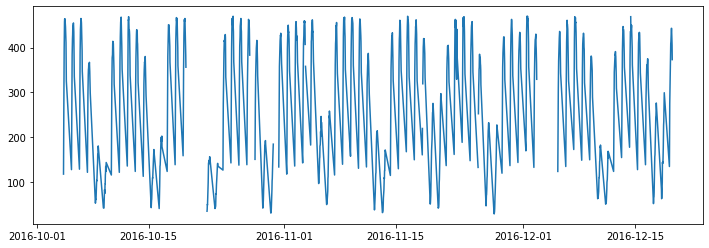

In [33]:
x2.index = x2.LastUpdated_round

pd.date_range(start='2018-01-01 08:00:00', periods=18, freq='30min')
pd.date_range(datetime(2018,1,1,8,0,0), periods=18, freq='30min')

for i in range((x2.LastUpdated_date.max() - x2.LastUpdated_date.min()).days + 1):
    if i == 0:
        d = pd.date_range(datetime(2016,10,4,8,0,0), periods=18, freq='30min')
    else:
        d = d.append(pd.date_range(datetime(2016,10,4,8,0,0)+timedelta(days=i), 
                           periods=18, freq='30min'))

x3 = pd.DataFrame(index=d)
x4 = x3.merge(x2, how='left', left_index=True, right_index=True)
x4['LastUpdated_round'] = x4.index
x4['LastUpdated_date'] = x4.LastUpdated_round.dt.date
plt.figure(figsize=(12,4))
plt.plot(x4.Occupancy)

<br>
And here is dates with missing observations. Some of them have just 1 missing data point some are missing all 18 data points.

In [34]:
x4[x4.Occupancy.isna()].groupby('LastUpdated_date')['LastUpdated_round'].count()

LastUpdated_date
2016-10-20    18
2016-10-21    18
2016-10-28     1
2016-10-30     2
2016-11-03     1
2016-11-18     1
2016-11-25     1
2016-12-03    18
2016-12-04    18
2016-12-13     1
2016-12-14     1
Name: LastUpdated_round, dtype: int64

<br>
Given that there is a clear weekly pattern in the series i will simply use observations from a week apart to fill missing points.

In [35]:
x4['Occupancy2'] = x4.Occupancy.shift(126)
x4.Occupancy2 = np.where(x4.Occupancy.isna(), x4.Occupancy2, x4.Occupancy)
x4.Occupancy2 = np.where(x4.Occupancy2.isna(), x4.Occupancy2.shift(126), x4.Occupancy2)
x4[x4.Occupancy2.isna()].groupby('LastUpdated_date')['LastUpdated_round'].count()

Series([], Name: LastUpdated_round, dtype: int64)

<br>
New series has no missing data points. Finally i can start fitting a model.

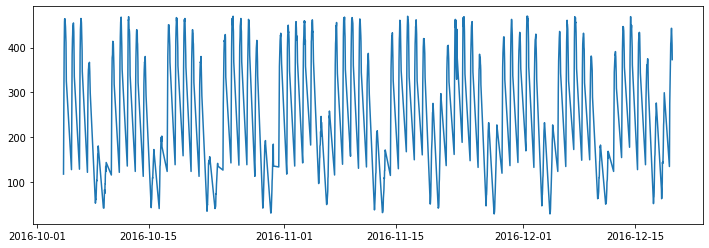

In [36]:
plt.figure(figsize=(12,4))
plt.plot(x4.Occupancy2)

<br>
<br>
Now let's look at ACF and PACF charts to determine which ARIMA model could be best for this data. First raw series without differencing:

Dickey-Fuller test p-value:  2.3497742894902963e-10


/home/kostya/anaconda3/envs/tf/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


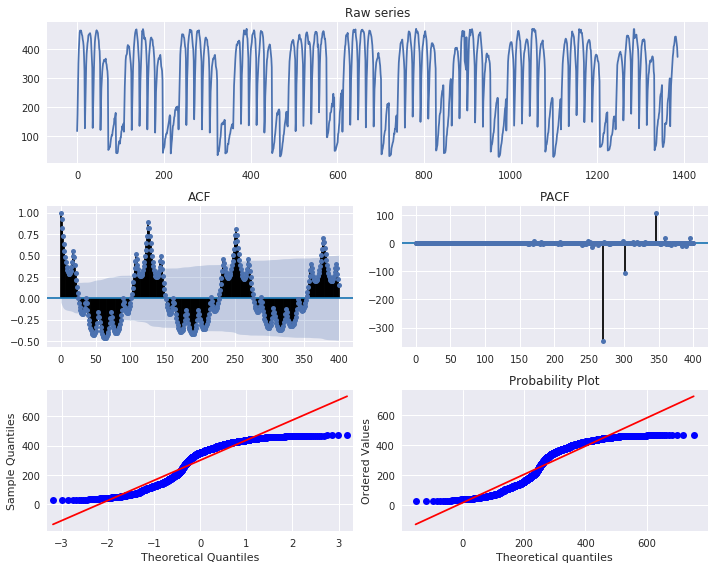

In [37]:
ch(np.array(x4.Occupancy2), "Raw series", lags=400)

<br>
<br>
There are a lot of significant lags on both ACF and PACF charts and distribution charts below doesn't look like normal distribution.

Dickey-Fuller test p-value:  2.3497742894902963e-10


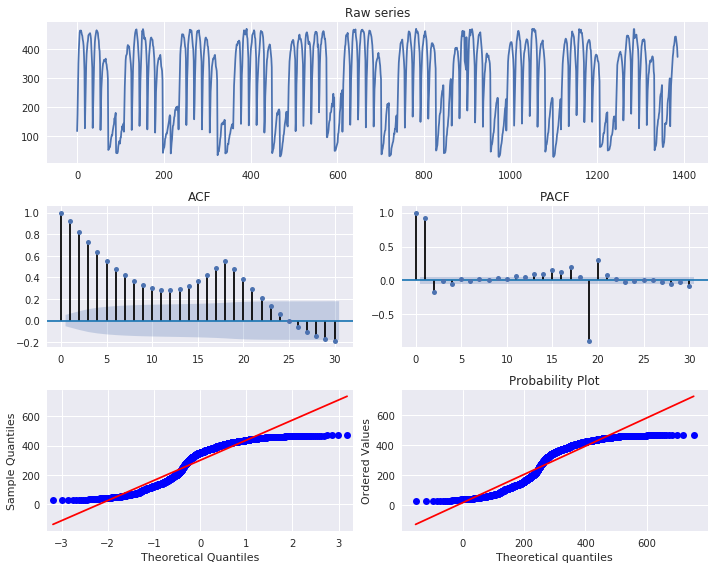

In [38]:
ch(np.array(x4.Occupancy2), "Raw series", lags=30)

<br>
<br>
Taking weekly difference improves things a bit. PACF chart shows 3 significant weekly lags - every 126 observations and ACF chart shows just one: (3,1,1,126) seasonal ARIMA model - (AR,I,MA,S) where S is a season length. It also could indicate a model with just 1 seasonal MA lag as AR lags are decreasing in size: (0,1,1,126) seasonal ARIMA model.

Dickey-Fuller test p-value:  0.00037587458499191927


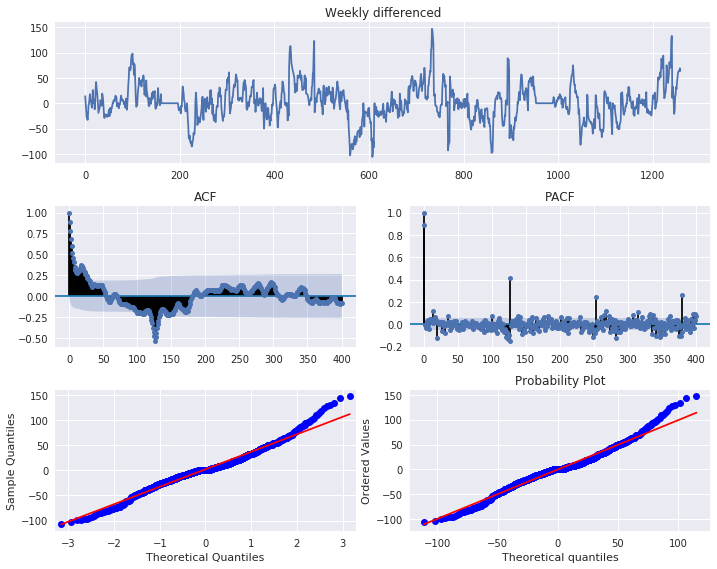

In [39]:
x4w = x4.Occupancy2 - x4.Occupancy2.shift(126)
ch(np.array(x4w.iloc[127:]), "Weekly differenced", lags=400)

<br>
<br>
Zooming in on weekly differenced series shows 1 highly significat PACF lag and mutliple significant ACF lags quickly decreasing which may indicate (1,0,0) ARIMA model.

Dickey-Fuller test p-value:  0.00037587458499191927


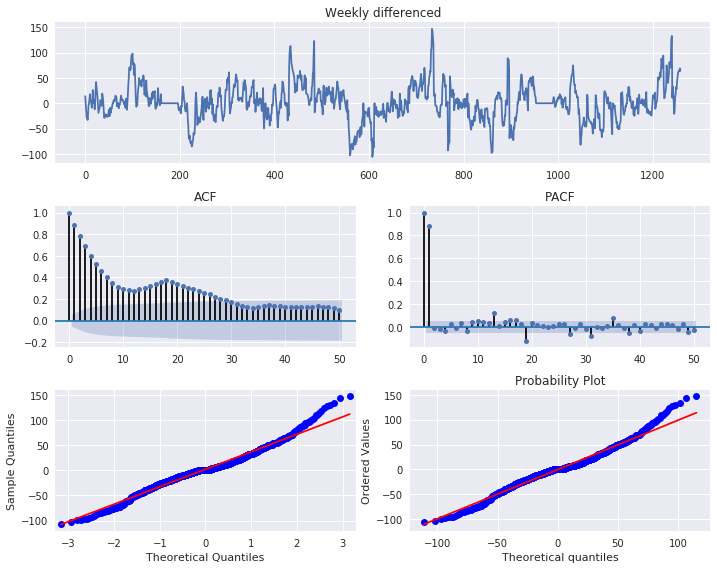

In [40]:
ch(np.array(x4w.iloc[127:]), "Weekly differenced", lags=50)

<br>
<br>
Adding simple difference to that shows again 1 significant lag on ACF chart and 3 significant ones on PACF chart suggesting either (3,1,1,126) or (0,1,1,126) seasonal ARIMA model.

Dickey-Fuller test p-value:  1.8949057577309586e-21


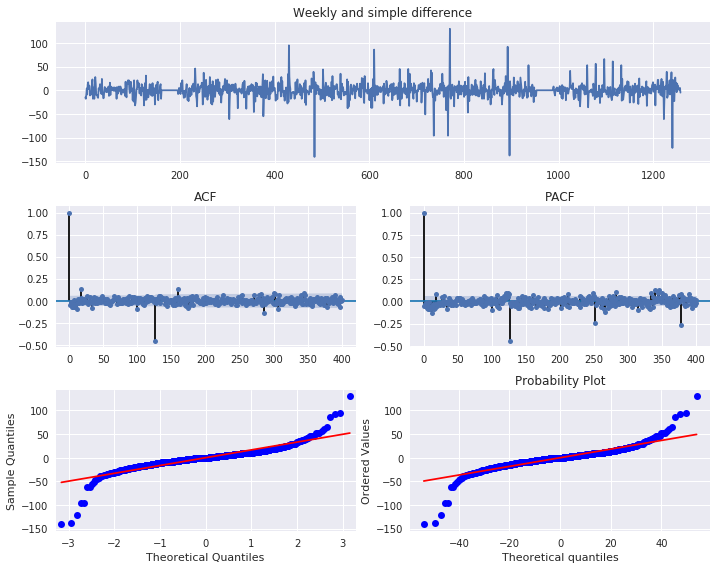

In [41]:
x4w1 = x4w - x4w.shift(1)
ch(np.array(x4w1.iloc[128:]), "Weekly and simple difference", lags=400)

<br>
<br>
Zoom in shows no highly significant lags on ACF/PACF charts indicating (0,1,0) ARIMA model - i just took simple difference.

Dickey-Fuller test p-value:  1.8949057577309586e-21


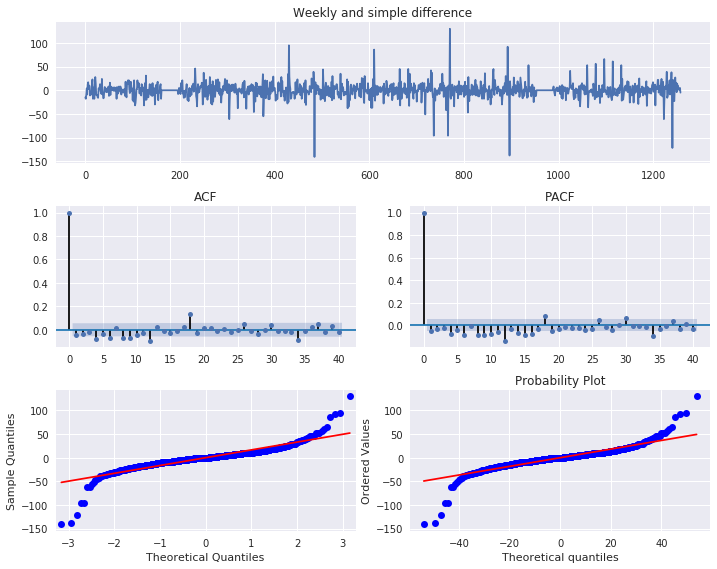

In [42]:
ch(np.array(x4w1.iloc[128:]), "Weekly and simple difference", lags=40)

<br>
<br>
I also looked at different combinations of differencing - daily, weekly and simple but none of them worked better than shown above.

Dickey-Fuller test p-value:  2.2831809023719354e-13


/home/kostya/anaconda3/envs/tf/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


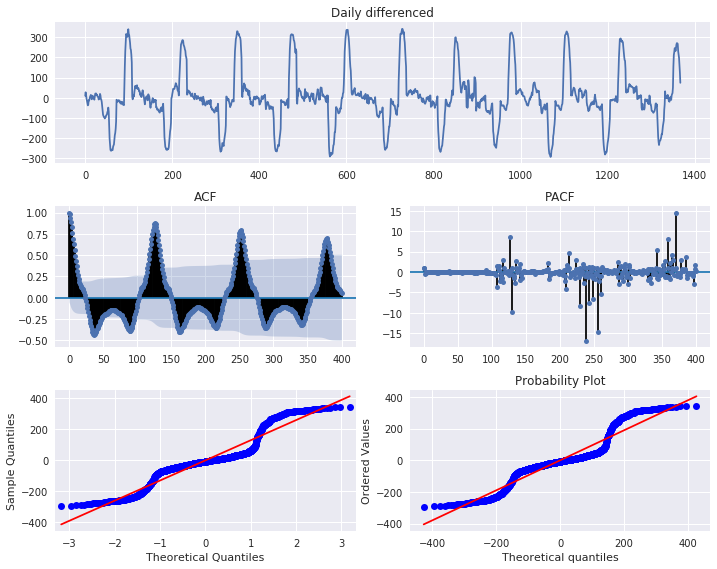

In [43]:
x4d = x4.Occupancy2 - x4.Occupancy2.shift(18)
ch(np.array(x4d.iloc[18:]), "Daily differenced", lags=400)

Dickey-Fuller test p-value:  2.2831809023719354e-13


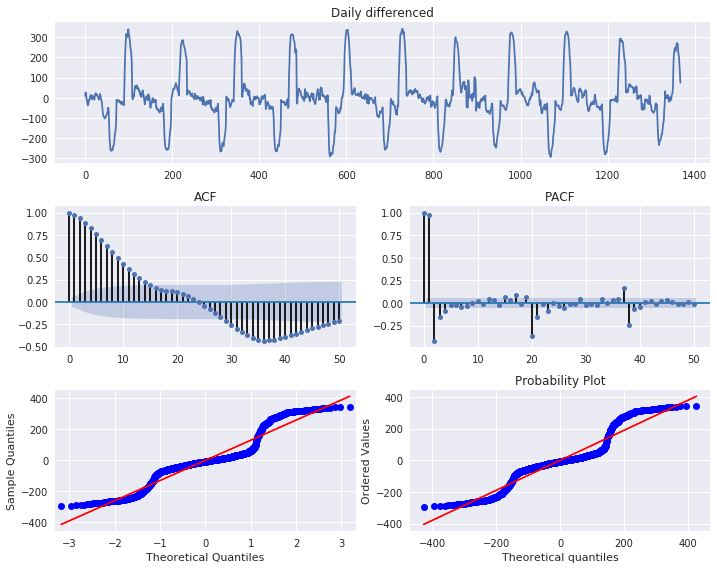

In [44]:
ch(np.array(x4d.iloc[18:]), "Daily differenced", lags=50)

<br>
<br>
Now i am going to test several seasonal and non seasonal models and see which one is better and why. Let me start with a simple non seasonal model. I will use cross validation function created before to test model performance out of sample based on mse.

Also please keep in mind that i am predicting one observation at a time. I will test models based on their ability to forecast a series of observations later as well.

In [45]:
auto_arima_grid_cv(x4.Occupancy2, 2, 4, 2, 4)

ARIMA(0, 0, 0), mse: 18600.409812995444, std: 235.14846927062717
ARIMA(0, 0, 1), mse: 7245.731233684854, std: 19.016176564939542
ARIMA(0, 0, 2), mse: 4727.17578640532, std: 141.39149044303167
ARIMA(0, 0, 3), mse: 3730.8089005660936, std: 104.68699604518224
ARIMA(0, 0, 4), mse: 6814.033674170812, std: 487.00944354060266
ARIMA(0, 1, 0), mse: 2941.0062614839608, std: 187.23777111492583
ARIMA(0, 1, 1), mse: 2896.3499448958532, std: 168.43025238355722
ARIMA(0, 1, 2), mse: 2895.7506277166226, std: 161.95457813179337
ARIMA(0, 1, 3), mse: 2895.7741261985148, std: 161.93533025553347
ARIMA(0, 1, 4), mse: 2882.6102462425943, std: 149.19162429039034
ARIMA(0, 2, 0), mse: 5167.060201698773, std: 249.885646282798
ARIMA(0, 2, 1), mse: 2949.773399703368, std: 193.55754525385692
ARIMA(0, 2, 2), mse: 2903.9613326760023, std: 173.3590369462063
ARIMA(0, 2, 3), mse: 2903.5465060775277, std: 167.35777119658883
ARIMA(0, 2, 4), mse: 2903.664289180498, std: 167.22417829849292
ARIMA(1, 0, 0), mse: 2824.826607013

<br>
<br>
Given that seasonality introduces a huge number of combinations it's not feasable to try each one like the approach above. I will try to limit number of combinations using ACF/PACF information and test one model at a time:

In [46]:
def ofs_cv1(x, n, order, seasonal_order=(0,0,0,0)):
    tscv = TimeSeriesSplit(n_splits=n)
    mse = []
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        for train, valid in tscv.split(x):
            try:
                model = SARIMAX(x[train], order=order, seasonal_order=seasonal_order, trend='c').fit(disp=False)
                predictions = SARIMAX(x, order=order, seasonal_order=seasonal_order, trend='c').filter(model.params).predict(start=valid[0], end=valid[-1])
                actuals = x[valid]
                mse.append(mean_squared_error(actuals, predictions))
            except Exception as error:
                print("ARIMA(order: %s, seasonal order: %s), : %s" % 
                      (order, seasonal_order, error)
                     )

        print("ARIMA(order: %s, seasonal order: %s), mse: %s, std: %s" % 
                      (order, seasonal_order, np.mean(np.array(mse)), np.std(np.array(mse)))
                     )

ofs_cv1(x4.Occupancy2, 2, (4,1,4))

ARIMA(order: (4, 1, 4), seasonal order: (0, 0, 0, 0)), mse: 2506.810841113187, std: 161.36365954524467


<br>
<br>
Just increasing number of lags in non seasonal ARIMA model to 18 which is number observations per day significantly improves accuracy of the model - mse droppes from 2506 to 619:

In [47]:
ofs_cv1(x4.Occupancy2, 2, (18,0,1))
ofs_cv1(x4.Occupancy2, 2, (18,1,1))
ofs_cv1(x4.Occupancy2, 2, (18,2,1))
ofs_cv1(x4.Occupancy2, 2, (1,0,18))
ofs_cv1(x4.Occupancy2, 2, (1,1,18))
ofs_cv1(x4.Occupancy2, 2, (1,2,18))

ARIMA(order: (18, 0, 1), seasonal order: (0, 0, 0, 0)), mse: 1706.421086284644, std: 207.0856459300685
ARIMA(order: (18, 1, 1), seasonal order: (0, 0, 0, 0)), mse: 622.320265186507, std: 176.37336933198588
ARIMA(order: (18, 2, 1), seasonal order: (0, 0, 0, 0)), mse: 619.1588018554453, std: 183.82890184565753
ARIMA(order: (1, 0, 18), seasonal order: (0, 0, 0, 0)), mse: 2180.266913879256, std: 910.52902655412
ARIMA(order: (1, 1, 18), seasonal order: (0, 0, 0, 0)), mse: 2138.707426763995, std: 839.8866763209188
ARIMA(order: (1, 2, 18), seasonal order: (0, 0, 0, 0)), mse: 2346.754206767952, std: 558.4805728173442


<br>
<br>
Introducing daily seasonality improves things even more - mse goes down to 264.

The reason i am using 7 as a factor for seasonal AR or MA is because there are 7 days in a week and based on actual observations there is a difference between them throughout the week and this trend repeats.

In [48]:
ofs_cv1(x4.Occupancy2, 2, (0,0,0), (7,0,1,18))
ofs_cv1(x4.Occupancy2, 2, (0,0,0), (7,1,1,18))
ofs_cv1(x4.Occupancy2, 2, (1,0,1), (7,0,1,18))
ofs_cv1(x4.Occupancy2, 2, (1,0,1), (7,1,1,18))
ofs_cv1(x4.Occupancy2, 2, (1,1,1), (7,1,1,18))
ofs_cv1(x4.Occupancy2, 2, (1,1,1), (1,0,7,18))

ARIMA(order: (0, 0, 0), seasonal order: (7, 0, 1, 18)), : LU decomposition error.
ARIMA(order: (0, 0, 0), seasonal order: (7, 0, 1, 18)), mse: 5786.167336606659, std: 0.0
ARIMA(order: (0, 0, 0), seasonal order: (7, 1, 1, 18)), : LU decomposition error.
ARIMA(order: (0, 0, 0), seasonal order: (7, 1, 1, 18)), mse: 2354.957993705882, std: 0.0
ARIMA(order: (1, 0, 1), seasonal order: (7, 0, 1, 18)), mse: 447.0984468857797, std: 160.7236950882133
ARIMA(order: (1, 0, 1), seasonal order: (7, 1, 1, 18)), mse: 264.2539291094058, std: 53.87045631032987
ARIMA(order: (1, 1, 1), seasonal order: (7, 1, 1, 18)), mse: 274.28134586677015, std: 59.2398534230217
ARIMA(order: (1, 1, 1), seasonal order: (1, 0, 7, 18)), mse: 744.1888175700204, std: 243.40153085471152


<br>
<br>
Now weekly seasonality takes a lot longer to train and cross validation is problematic due to not long enough series but the improvement is clear - mse is just 144. So weekly seasonal ARIMA is the winner as the data definitely shows weekly pattern.

By the way the most accurate weekly seasonal model based on this validation sample is exactly like ACF/PACF charts suggested before: order=(1,0,0) and seasonal_order=(0,1,1,126)

In [49]:
ofs_cv1(x4.Occupancy2, 2, (1,0,0), (0,1,1,126))

ARIMA(order: (1, 0, 0), seasonal order: (0, 1, 1, 126)), : maxlag should be < nobs
ARIMA(order: (1, 0, 0), seasonal order: (0, 1, 1, 126)), mse: 144.5977765775498, std: 0.0


In [50]:
ofs_cv1(x4.Occupancy2, 2, (1,0,0), (1,1,1,126))

ARIMA(order: (1, 0, 0), seasonal order: (1, 1, 1, 126)), : maxlag should be < nobs
ARIMA(order: (1, 0, 0), seasonal order: (1, 1, 1, 126)), mse: 150.6407729787602, std: 0.0


In [38]:
ofs_cv1(x4.Occupancy2, 2, (1,0,0), (3,1,1,126))

ARIMA(order: (1, 0, 0), seasonal order: (3, 1, 1, 126)), : maxlag should be < nobs
ARIMA(order: (1, 0, 0), seasonal order: (3, 1, 1, 126)), mse: 146.58908742067533, std: 0.0


In [39]:
ofs_cv1(x4.Occupancy2, 2, (0,1,0), (0,1,1,126))

ARIMA(order: (0, 1, 0), seasonal order: (0, 1, 1, 126)), : maxlag should be < nobs
ARIMA(order: (0, 1, 0), seasonal order: (0, 1, 1, 126)), mse: 152.90780020751467, std: 0.0


<br>
<br>
As i said i would also like to see which model is the best at predicting a series of observations at a time. Let's just try to predict 36 data points which corresponds to 2 days. The below function will help with that.

In [40]:
def ofs_cv2(x, n, order, seasonal_order=(0,0,0,0)):
    tscv = TimeSeriesSplit(n_splits=n)
    mse = []
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        for train, valid in tscv.split(x):
            try:
                model = SARIMAX(x[train], order=order, seasonal_order=seasonal_order, trend='c').fit(disp=False)
                predictions = model.predict(start=valid[0], end=valid[36])
                actuals = x[valid[0]:valid[37]]
                mse.append(mean_squared_error(actuals, predictions))
            except Exception as error:
                print("ARIMA(order: %s, seasonal order: %s), : %s" % 
                      (order, seasonal_order, error)
                     )

        print("ARIMA(order: %s, seasonal order: %s), mse: %s, std: %s" % 
                      (order, seasonal_order, np.mean(np.array(mse)), np.std(np.array(mse)))
                     )

In [41]:
ofs_cv2(x4.Occupancy2, 2, (4,1,4))

ARIMA(order: (4, 1, 4), seasonal order: (0, 0, 0, 0)), mse: 25857.796747793134, std: 10241.662502430921


<br>
<br>
In this exercise performance of the models may differ relative to each other due to different reasons but overall dynamic is the same - introducing more lags helps with accuracy:

In [42]:
ofs_cv2(x4.Occupancy2, 2, (18,0,1))
ofs_cv2(x4.Occupancy2, 2, (18,1,1))
ofs_cv2(x4.Occupancy2, 2, (18,2,1))
ofs_cv2(x4.Occupancy2, 2, (1,0,18))
ofs_cv2(x4.Occupancy2, 2, (1,1,18))
ofs_cv2(x4.Occupancy2, 2, (1,2,18))

ARIMA(order: (18, 0, 1), seasonal order: (0, 0, 0, 0)), mse: 23125.326439092445, std: 739.6183485251404
ARIMA(order: (18, 1, 1), seasonal order: (0, 0, 0, 0)), mse: 43406.912541373626, std: 32311.450730092427
ARIMA(order: (18, 2, 1), seasonal order: (0, 0, 0, 0)), mse: 90254.29460567169, std: 83647.65874120752
ARIMA(order: (1, 0, 18), seasonal order: (0, 0, 0, 0)), mse: 10476.807649760094, std: 2521.668913819514
ARIMA(order: (1, 1, 18), seasonal order: (0, 0, 0, 0)), mse: 45874.79286801901, std: 19380.38342903796
ARIMA(order: (1, 2, 18), seasonal order: (0, 0, 0, 0)), mse: 57215.86933092007, std: 46857.80805403747


<br>
<br>
And introducing daily seasonality helps even better:

In [43]:
ofs_cv2(x4.Occupancy2, 2, (0,0,0), (7,0,1,18))
ofs_cv2(x4.Occupancy2, 2, (0,0,0), (7,1,1,18))
ofs_cv2(x4.Occupancy2, 2, (1,0,1), (7,0,1,18))
ofs_cv2(x4.Occupancy2, 2, (1,0,1), (7,1,1,18))
ofs_cv2(x4.Occupancy2, 2, (1,1,1), (7,1,1,18))
ofs_cv2(x4.Occupancy2, 2, (1,1,1), (1,0,7,18))

ARIMA(order: (0, 0, 0), seasonal order: (7, 0, 1, 18)), : LU decomposition error.
ARIMA(order: (0, 0, 0), seasonal order: (7, 0, 1, 18)), mse: 4913.128289720797, std: 0.0
ARIMA(order: (0, 0, 0), seasonal order: (7, 1, 1, 18)), : LU decomposition error.
ARIMA(order: (0, 0, 0), seasonal order: (7, 1, 1, 18)), mse: 2083.771850417866, std: 0.0
ARIMA(order: (1, 0, 1), seasonal order: (7, 0, 1, 18)), mse: 3960.7358558291708, std: 3179.0326745911525
ARIMA(order: (1, 0, 1), seasonal order: (7, 1, 1, 18)), mse: 492.10914876744437, std: 34.26924992620317
ARIMA(order: (1, 1, 1), seasonal order: (7, 1, 1, 18)), mse: 568.4403726131634, std: 62.41458052510015
ARIMA(order: (1, 1, 1), seasonal order: (1, 0, 7, 18)), mse: 52310.42046022808, std: 15553.325861564372


<br>
<br>
Now the winner is still weekly seasonal model but a different one at this time - order=(0,1,0), seasonal_order=(0,1,1,126). Something that ACF/PACF charts suggested too.

In [44]:
ofs_cv2(x4.Occupancy2, 2, (1,0,0), (0,1,1,126))
ofs_cv2(x4.Occupancy2, 2, (1,0,0), (1,1,1,126))
ofs_cv2(x4.Occupancy2, 2, (0,1,0), (0,1,1,126))

ARIMA(order: (1, 0, 0), seasonal order: (0, 1, 1, 126)), : maxlag should be < nobs
ARIMA(order: (1, 0, 0), seasonal order: (0, 1, 1, 126)), mse: 487.4146882868807, std: 0.0
ARIMA(order: (1, 0, 0), seasonal order: (1, 1, 1, 126)), : maxlag should be < nobs
ARIMA(order: (1, 0, 0), seasonal order: (1, 1, 1, 126)), mse: 444.647006137894, std: 0.0
ARIMA(order: (0, 1, 0), seasonal order: (0, 1, 1, 126)), : maxlag should be < nobs
ARIMA(order: (0, 1, 0), seasonal order: (0, 1, 1, 126)), mse: 181.82431940864382, std: 0.0


<br>
<br>
More complex weekly seasonal model with 3 AR coefficients didn't improve things enough to become a winner:

In [45]:
ofs_cv2(x4.Occupancy2, 2, (1,0,0), (3,1,1,126))

ARIMA(order: (1, 0, 0), seasonal order: (3, 1, 1, 126)), : maxlag should be < nobs
ARIMA(order: (1, 0, 0), seasonal order: (3, 1, 1, 126)), mse: 293.73062430783517, std: 0.0


<br>
<br>
I was curious why non seasonal models so bad at predicting a series of observations at a time with a seasonal pattern. Let's look at how predicted values compare against actuals to understand that. Here is ARIMA(4,1,4), orange line is predicted values. It can only tell us what mean of the actuals may look like. That's why performance is so bad.

mse:  10406.804016825718


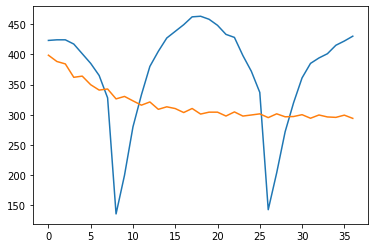

In [51]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    model = SARIMAX(x4.Occupancy2[:1000], order=(4,1,4), trend='c').fit(disp=False)
    predictions = model.predict(start=1000, end=1036)
    actuals = x4.Occupancy2[1000:1037]
    print("mse: ", mean_squared_error(actuals, predictions))
    plt.plot(np.array(actuals))
    plt.plot(np.array(predictions))

<br>
<br>
Increasing number of lags only allows a non seasonal model to correctly spot the first change in trend - from downward to upward. 

mse:  7225.859671594105


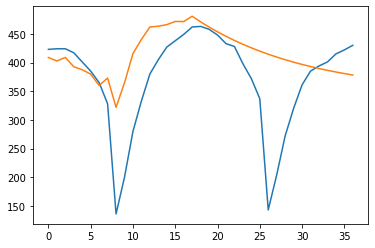

In [52]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    model = SARIMAX(x4.Occupancy2[:1000], order=(1,0,18), trend='c').fit(disp=False)
    predictions = model.predict(start=1000, end=1036)
    actuals = x4.Occupancy2[1000:1037]
    print("mse: ", mean_squared_error(actuals, predictions))
    plt.plot(np.array(actuals))
    plt.plot(np.array(predictions))

<br>
<br>
ARIMA with daily seasonal factor is much better at differentiating each particular day:

mse:  1943.6249924614774


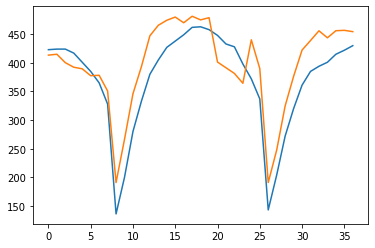

In [55]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    model = SARIMAX(x4.Occupancy2[:1000], order=(1,0,1), seasonal_order=(7,1,1,18), trend='c').fit(disp=False)
    predictions = model.predict(start=1000, end=1036)
    actuals = x4.Occupancy2[1000:1037]
    print("mse: ", mean_squared_error(actuals, predictions))
    plt.plot(np.array(actuals))
    plt.plot(np.array(predictions))

<br>
<br>
And just for comparison here is how simple ARIMA(4,1,4) performs trying to make predictions one at a time. It's always late to spot change in trend but still pretty close to actuals. So for seasonal series it's necessary to use seasonal model when making multiple observations at a time but in other cases simple model can be a rough alternative.

mse:  2504.191512249002


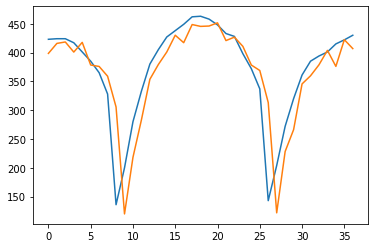

In [56]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    model = SARIMAX(x4.Occupancy2[:1000], order=(4,1,4), trend='c').fit(disp=False)
    predictions = SARIMAX(x4.Occupancy2[:1037], order=(4,1,4), trend='c').filter(model.params).predict(start=1000, end=1036)
    actuals = x4.Occupancy2[1000:1037]
    print("mse: ", mean_squared_error(actuals, predictions))
    plt.plot(np.array(actuals))
    plt.plot(np.array(predictions))

<br>
<br>
Finally the champion model - weekly seasonal ARIMA:

One last thing to notice is that based on Ljung-Box test below i should reject null hypothesis for no autocorrelation in the residuals and based on heteroscedasticity test below i should reject null hypothesis for no heteroscedasticity in the residuals. Unfortunately the model was not able to get rid of that but i assume it's related to noise in the actual  observations as every other model i tested on this data had similar issues.

mse:  760.649254461138


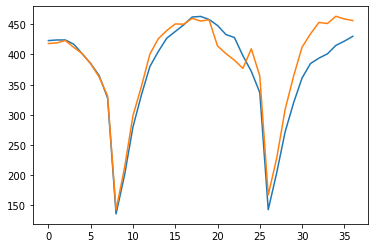

In [53]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    model = SARIMAX(x4.Occupancy2[:1000], order=(0,1,0), seasonal_order=(0,1,1,126), trend='c').fit(disp=False)
    predictions = model.predict(start=1000, end=1036)
    actuals = x4.Occupancy2[1000:1037]
    print("mse: ", mean_squared_error(actuals, predictions))
    plt.plot(np.array(actuals))
    plt.plot(np.array(predictions))

In [54]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  Statespace Model Results                                 
===========================================================================================
Dep. Variable:                          Occupancy2   No. Observations:                 1000
Model:             SARIMAX(0, 1, 0)x(0, 1, 1, 126)   Log Likelihood               -3564.212
Date:                             Sat, 23 Nov 2019   AIC                           7134.423
Time:                                     10:43:07   BIC                           7148.739
Sample:                                          0   HQIC                          7139.900
                                            - 1000                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0103      0.235     -0.044      0.965      -0.470       0.450
ma.S.L126     -0.5867      0.021    -27.329      0.000      -0.629      -0.545
sigma2       193.7789      2.633     73.585      0.000     188.618     198.940
===================================================================================
Ljung-Box (Q):                       75.46   Jarque-Bera (JB):             19882.70
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.49   Skew:                            -0.64
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<br>
<br>
To summarize all the above, i was able to better understand time series ARIMA models and apply it on real world data, properly select best model using cross validation and out of sample testing and visually observe pros and cons of seasonal and non seasonal ARIMA models.